In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from fastseg import MobileV3Small
from fastseg.image.colorize import colorize, blend
from dataloader import UROBDataset
import torchvision.transforms as transforms
import torchvision
import cv2
from PIL import Image
from tqdm import tqdm
from utils import *
from lovacs_losses import lovasz_softmax
from torch.utils.tensorboard import SummaryWriter

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda:0'
if not torch.cuda.is_available():
    device = 'cpu'

print(device)

cuda:0


In [3]:
# dataset config
label_mapping = {
    2 : 1 # car
}
ignore_label = 32
unique_labels = [0] + [label_mapping[key] for key in label_mapping.keys()]
label_names = ['other', 'rb_car']

# model save paths
model_save_path = './experiments/init_test/model.pt'
model_checkpoint_save_path = './experiments/init_test/checkpoint.pt'

# tensorboard logging
#tb_log_save_path = './experiments/init_test/log'
writer = SummaryWriter() # uncomment for tensorboard

# construct the dataset
target_shape = [512, 1024]
train_dataset = UROBDataset(filenames_file='./experiments/init_test/train_filenames.pkl', target_img_shape=target_shape, label_mapping=label_mapping)
val_dataset = UROBDataset(filenames_file='./experiments/init_test/val_filenames.pkl', target_img_shape=target_shape, label_mapping=label_mapping)
batch_size = 4

# construct the dataloader
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation([-180, 180])
])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                          shuffle=True, num_workers=1)

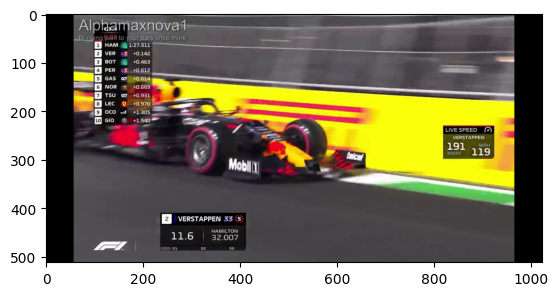

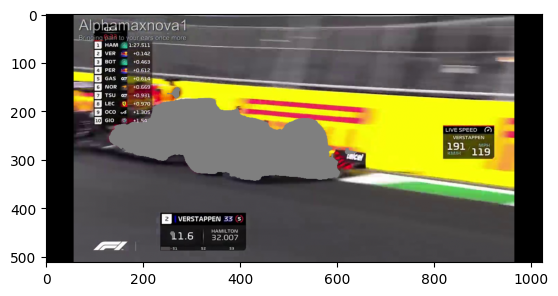

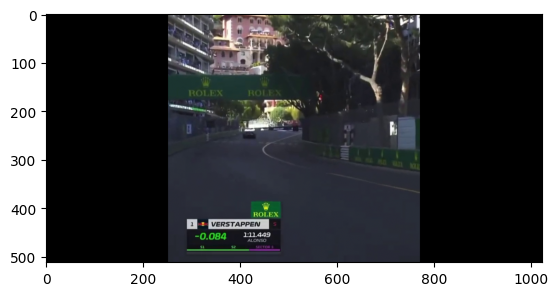

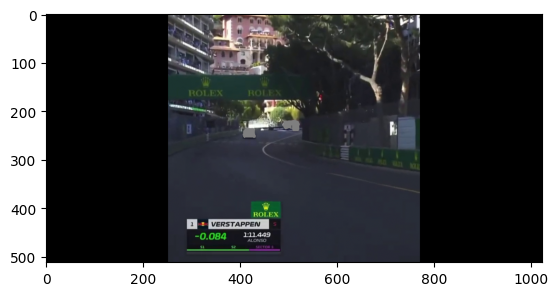

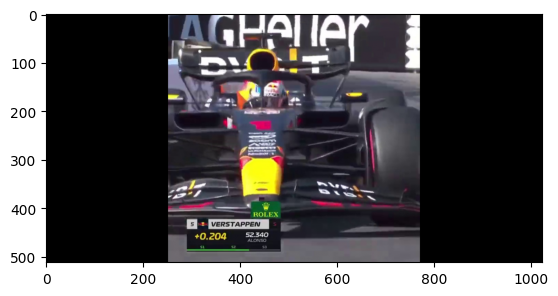

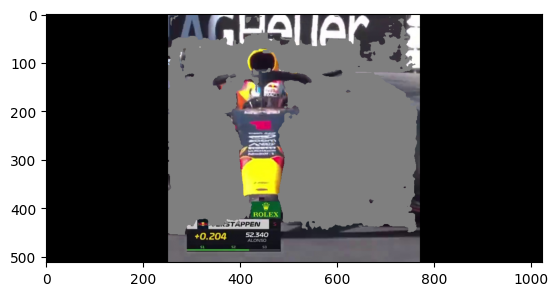

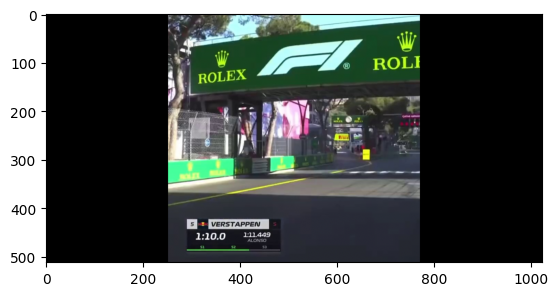

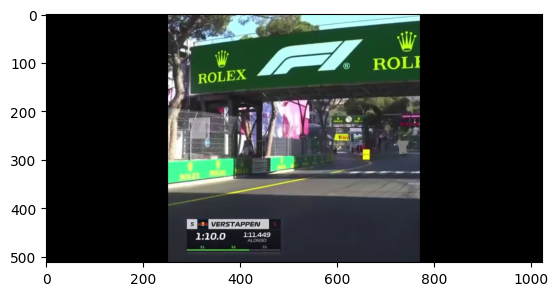

In [4]:
def imshow(img):
    img = (img + 1) / 2  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
for i in range(images.shape[0]):
    image = images[i, :, :, :]
    label = labels[i, :, :]
    seg_image = image.clone()
    seg_image[:, label==1] = 0
    imshow(image)
    imshow(seg_image)


In [5]:

# define model and optimizer
learning_rate = 1e-3
weight_decay = learning_rate * 0
num_epoch = 20

model = MobileV3Small(num_classes=2)
model = model.to(device=device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=0.9)

# CE loss
#criterion = torch.nn.CrossEntropyLoss(reduction="none", weight=None, ignore_index=ignore_label)

# lovasc softmax
def criterion(outputs, labels):
    loss = lovasz_softmax(outputs, labels, ignore=ignore_label) #+ torch.nn.functional.cross_entropy(outputs, labels, ignore_index=ignore_label, reduction='mean')
    return loss

In [6]:

best_val_miou = -torch.inf
total_iter = 0

for epoch in range(num_epoch):
    pbar = tqdm(total=len(train_loader))

    for iter, data in enumerate(train_loader):
        X_trn, y_trn = data
        # TODO() augmentation to the dataloader

        # augment the data
        #if torch.rand(1).item() > 0.5:
        #    X_trn = transform(X_trn)             

        # run through model
        X_trn = X_trn.float().to(device=device)
        y_trn = y_trn.long().to(device=device)
        output = model(X_trn)

        # compute loss
        loss = criterion(output, y_trn)
        pbar.set_description(f'epoch: {epoch} | loss: {loss.detach().item():.4f}')
        writer.add_scalar('Loss/Train', loss.item(), total_iter) # uncomment for tensorboard

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_iter += 1
        pbar.update(1)
    pbar.close()
    lr_scheduler.step()


    # validate model
    loss_hist, cls_tp_hist, cls_tn_hist, cls_fp_hist, cls_fn_hist = validate(
        val_dataloader=val_loader,
        model=model,
        criterion=criterion,
        unique_labels = unique_labels,
        device=device
    )

    # print stats
    loss_mean = loss_hist.mean().item()
    cls_iou = compute_cls_iou(cls_tp=cls_tp_hist, cls_tn=cls_tn_hist, cls_fp=cls_fp_hist, cls_fn=cls_fn_hist)
    miou = cls_iou.mean().item()
    print(f'epoch: {epoch} results: ')
    print(f'loss: {loss_mean}')
    for i  in range(len(label_names)):
        print(f'class {label_names[i]} IoU: {100 * cls_iou[i].item()}%')
    print(f'mIoU: {miou * 100}% / best mIoU: {best_val_miou * 100}%')

    # save progress
    if best_val_miou < miou:
        best_val_miou = miou
        with open(model_save_path, 'wb') as file:
            torch.save(model.state_dict(), file)
    with open(model_checkpoint_save_path, 'wb') as file:
            torch.save(model.state_dict(), file)
        

  0%|          | 0/203 [00:00<?, ?it/s]